# Analyse de donnée - Groupe 6
Le présent notebook contient la partie analyse de donnée du groupe 6 pour le TPA


## Préparation de l'environnement

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, HiveContext

In [4]:
"""
SparkSession ss = SparkSession
.builder()
.appName(" Hive example")
.config("hive.metastore.uris", "thrift://localhost:10000")
.enableHiveSupport()
.getOrCreate();
"""

sparkSession = (SparkSession
                .builder
                .appName('example-pyspark-read-and-write-from-hive-now')
                .config("hive.metastore.uris", "thrift://localhost:9083")
                .enableHiveSupport()
                .getOrCreate()
                )


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [486]:
# Pour tester si on est vraiment connecter à Hive
sparkSession.sql("SHOW TABLES").show()

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|  default|       catalogue_co2|      false|
|  default|catalogue_oraclen...|      false|
|  default|        client_mongo|      false|
|  default| client_mongo_extern|      false|
|  default|             co2_ext|      false|
|  default|        co2_hdfs_ext|      false|
|  default|immatriculation_h...|      false|
|  default|immatriculation_o...|      false|
|  default|marketing_mongo_e...|      false|
|  default| table_catalogue_co2|      false|
+---------+--------------------+-----------+



# Analyse des données Exploratoire

## Importation des données

In [7]:
df_catalogue = sparkSession.sql("SELECT * FROM catalogue_co2")

In [29]:
df_client = sparkSession.sql("SELECT * FROM client_mongo_extern")

In [9]:
df_marketing = sparkSession.sql("SELECT * FROM marketing_mongo_extern")

In [10]:
df_immatriculation = sparkSession.sql("SELECT * FROM immatriculation_hdfs_extern")

## Extraction des informations sur les données

### Nombre de donnée par source

In [490]:
df_client.count()

200000

In [489]:
df_marketing.count()

24/06/08 21:45:53 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


20

In [488]:
df_immatriculation.count()

2000001

In [487]:
df_catalogue.count()

270

## Identification des valeurs manquantes

In [494]:
from pyspark.sql.functions import col, count, when, isnan, isnull

In [491]:
def missing_count(df):
    return df.select([(count(when(isnull(c), c))/df.count()).alias(c) for c in df.columns])

In [495]:
missing_values_catalogue_co2 = missing_count(df_catalogue)
missing_values_catalogue_co2.show()

+---+----------------+---+---------+--------+--------+--------+-------+--------+----+----------+---------+-----------+
| id|marque_corrected|nom|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|malusbonus|rejetsco2|coutenergie|
+---+----------------+---+---------+--------+--------+--------+-------+--------+----+----------+---------+-----------+
|0.0|             0.0|0.0|      0.0|     0.0|     0.0|     0.0|    0.0|     0.0| 0.0|       0.0|      0.0|        0.0|
+---+----------------+---+---------+--------+--------+--------+-------+--------+----+----------+---------+-----------+



In [496]:
missing_values_client_mongo_extern = missing_count(df_client)
missing_values_client_mongo_extern.show()

+---+---+----+----+------------------+----------------+----------------+---------------+
| id|age|sexe|taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|immatriculation|
+---+---+----+----+------------------+----------------+----------------+---------------+
|0.0|0.0| 0.0| 0.0|               0.0|             0.0|             0.0|            0.0|
+---+---+----+----+------------------+----------------+----------------+---------------+



## Identification des valeurs doublons

In [497]:
duplicates_catalogue_co2 = df_catalogue.groupBy(df_catalogue.columns).count().filter("count > 1")
duplicates_catalogue_co2.show()

+---+----------------+---+---------+--------+--------+--------+-------+--------+----+----------+---------+-----------+-----+
| id|marque_corrected|nom|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|malusbonus|rejetsco2|coutenergie|count|
+---+----------------+---+---------+--------+--------+--------+-------+--------+----+----------+---------+-----------+-----+
+---+----------------+---+---------+--------+--------+--------+-------+--------+----+----------+---------+-----------+-----+



<p>Il n'y  pas de doublon dans catalogue_co2</p> 

In [498]:
duplicates_client_mongo_extern = df_client.groupBy(df_client.columns).count().filter("count > 1")
duplicates_client_mongo_extern.show()

+---+---+----+----+------------------+----------------+----------------+---------------+-----+
| id|age|sexe|taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|immatriculation|count|
+---+---+----+----+------------------+----------------+----------------+---------------+-----+
+---+---+----+----+------------------+----------------+----------------+---------------+-----+



<p>Il n'y  pas de doublon dans client_mongo_extern</p>

In [554]:
import matplotlib.pyplot as plt
import seaborn as sns

In [552]:
pdf_catalogue_co2 = df_catalogue.toPandas()

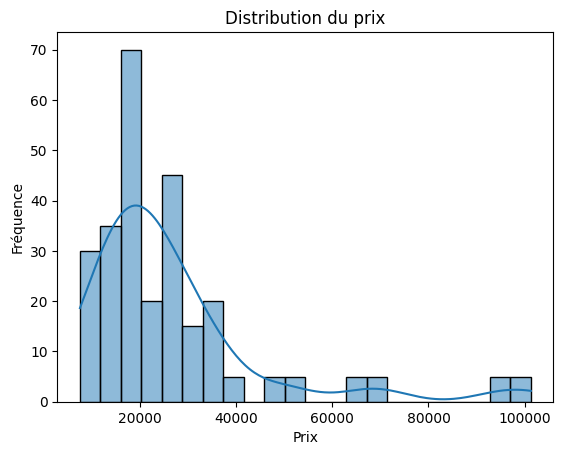

In [555]:
sns.histplot(pdf_catalogue_co2['prix'].astype(float), kde=True)
plt.title('Distribution du prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()

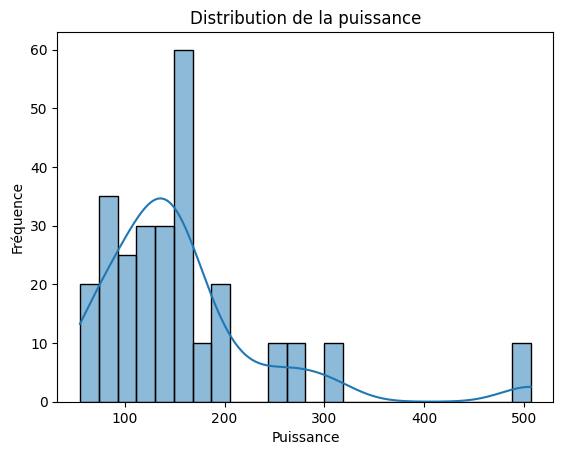

In [556]:
sns.histplot(pdf_catalogue_co2['puissance'], kde=True)
plt.title('Distribution de la puissance')
plt.xlabel('Puissance')
plt.ylabel('Fréquence')
plt.show()

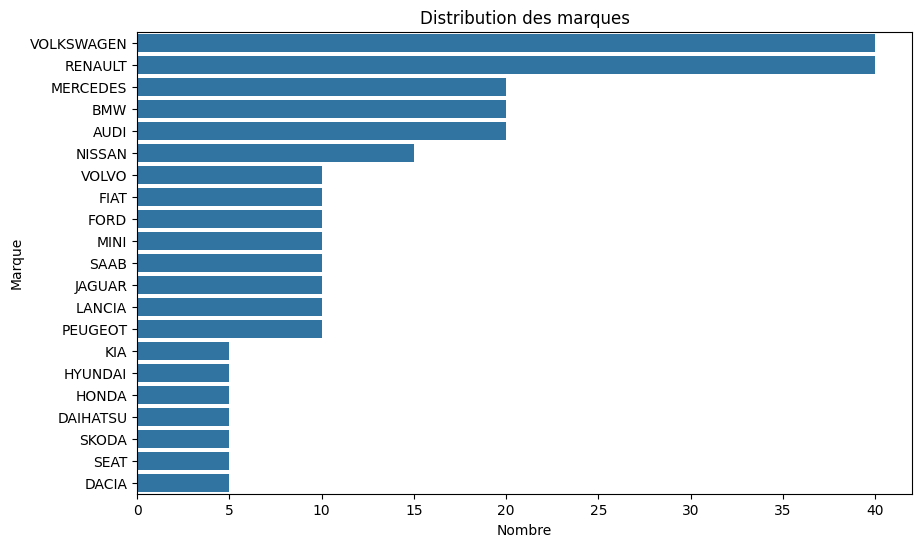

In [557]:
plt.figure(figsize=(10, 6))
sns.countplot(y='marque_corrected', data=pdf_catalogue_co2, order=pdf_catalogue_co2['marque_corrected'].value_counts().index)
plt.title('Distribution des marques')
plt.xlabel('Nombre')
plt.ylabel('Marque')
plt.show()

In [559]:
pdf_client_mongo_extern = df_client.toPandas()

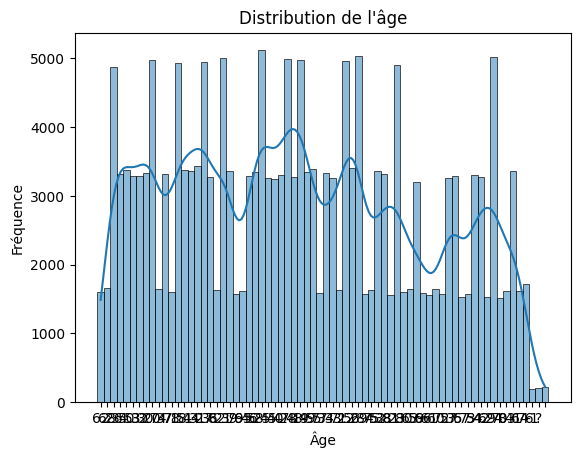

In [560]:
sns.histplot(pdf_client_mongo_extern['age'], kde=True)
plt.title('Distribution de l\'âge')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

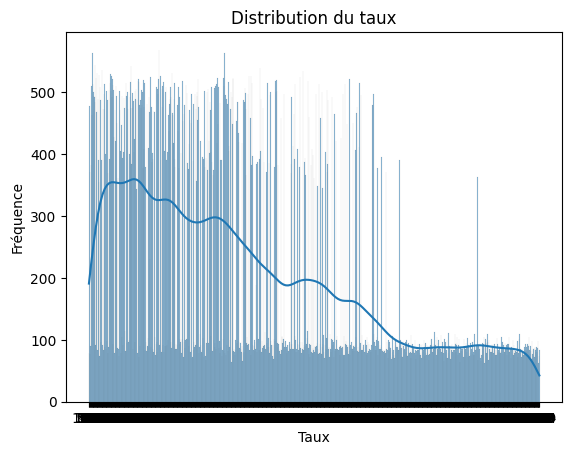

In [561]:
sns.histplot(pdf_client_mongo_extern['taux'], kde=True)
plt.title('Distribution du taux')
plt.xlabel('Taux')
plt.ylabel('Fréquence')
plt.show()

## Variables liées

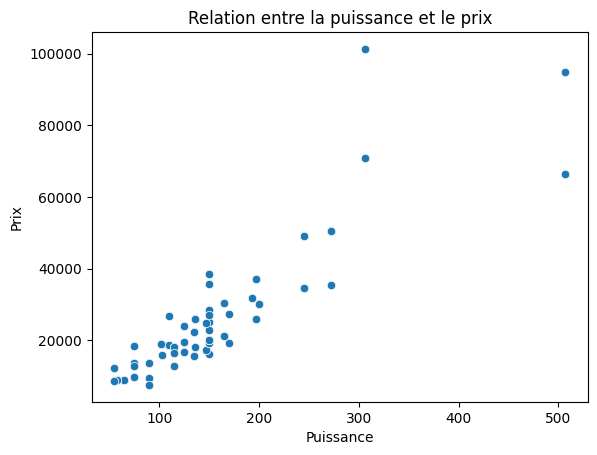

In [562]:
sns.scatterplot(x='puissance', y=pdf_catalogue_co2['prix'].astype(float), data=pdf_catalogue_co2)
plt.title('Relation entre la puissance et le prix')
plt.xlabel('Puissance')
plt.ylabel('Prix')
plt.show()

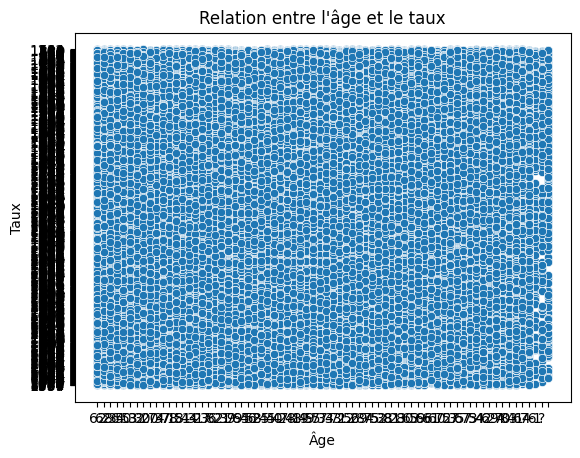

In [563]:
sns.scatterplot(x='age', y='taux', data=pdf_client_mongo_extern)
plt.title('Relation entre l\'âge et le taux')
plt.xlabel('Âge')
plt.ylabel('Taux')
plt.show()

### Descriptions des données 

#### Client

In [544]:
df_client.describe().show()

24/06/09 13:18:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+------+-----------------+------------------+------------------+----------------+---------------+
|summary|                  id|               age|  sexe|             taux|situationfamiliale|  nbenfantsacharge|deuxieme_voiture|immatriculation|
+-------+--------------------+------------------+------+-----------------+------------------+------------------+----------------+---------------+
|  count|              200000|            200000|200000|           200000|            200000|            200000|          200000|         200000|
|   mean|                NULL| 43.68149929845661|  NULL|608.1501067358863|              NULL|1.2483113525214464|            NULL|           NULL|
| stddev|                NULL|18.340335375894824|  NULL|335.4038183527258|              NULL|1.3875727205511366|            NULL|           NULL|
|    min|665ae8f7f79a7173f...|                  |      |                 |                  |                  |            

In [22]:
df_immatriculation.describe().show()

+-------+---------------+-------+--------+------------------+-----------+--------+------------------+-------+-----------------+
|summary|immatriculation| marque|     nom|         puissance|   longueur|nbplaces|          nbportes|couleur|             prix|
+-------+---------------+-------+--------+------------------+-----------+--------+------------------+-------+-----------------+
|  count|        2000001|2000001| 2000001|           2000000|    2000001| 2000000|           2000000|2000001|          2000001|
|   mean|           NULL|   NULL|    NULL|       199.0421865|       NULL|     5.0|          4.868432|   NULL|    35782.5696715|
| stddev|           NULL|   NULL|    NULL|137.14856637845043|       NULL|     0.0|0.4958084149033565|   NULL|25775.64060807992|
|    min|        0 AB 42|   Audi|1007 1.4|                55|     courte|       5|                 3|  blanc|           101300|
|    max|immatriculation| marque|     nom|               507|tr�s longue|       5|                 5|  r

In [23]:
df_marketing.describe().show()

24/06/07 00:57:20 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


+-------+--------------------+------------------+----+------------------+------------------+----------------+----------------+
|summary|                  id|               age|sexe|              taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|
+-------+--------------------+------------------+----+------------------+------------------+----------------+----------------+
|  count|                  20|                20|  20|                20|                 0|               0|              20|
|   mean|                NULL|              45.0|NULL|             582.4|              NULL|            NULL|            NULL|
| stddev|                NULL|19.246325691715263|NULL|345.65611142929475|              NULL|            NULL|            NULL|
|    min|665caa3cf79a7173f...|                19|   F|              1112|              NULL|            NULL|           false|
|    max|665caa3cf79a7173f...|                80|   M|               981|              NULL|            NULL|  

In [25]:
df_catalogue.describe().show()

+-------+-----------------+----------------+---------------+------------------+-----------+------------------+------------------+-------+------------------+-------------------+-----------------+------------------+
|summary|               id|marque_corrected|            nom|         puissance|   longueur|          nbplaces|          nbportes|couleur|              prix|         malusbonus|        rejetsco2|       coutenergie|
+-------+-----------------+----------------+---------------+------------------+-----------+------------------+------------------+-------+------------------+-------------------+-----------------+------------------+
|  count|              270|             270|            270|               270|        270|               270|               270|    270|               270|                270|              270|               270|
|   mean|            134.5|            NULL|           NULL|157.59259259259258|       NULL| 5.222222222222222| 4.814814814814815|   NULL|26668.0

## Exemple de contenue 

In [30]:
df_client.show(2)

+--------------------+---+----+----+------------------+----------------+----------------+---------------+
|                  id|age|sexe|taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|immatriculation|
+--------------------+---+----+----+------------------+----------------+----------------+---------------+
|665ae8f7f79a7173f...| 62|   M|1262|         En Couple|               1|           false|     6290 DM 24|
|665ae8f7f79a7173f...| 68|   M| 514|         En Couple|               2|           false|     7530 VH 52|
+--------------------+---+----+----+------------------+----------------+----------------+---------------+
only showing top 2 rows



In [27]:
df_immatriculation.show(2)

+---------------+-------+-----------+---------+--------+--------+--------+-------+--------+-----+
|immatriculation| marque|        nom|puissance|longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+-------+-----------+---------+--------+--------+--------+-------+--------+-----+
|immatriculation| marque|        nom|     NULL|longueur|    NULL|    NULL|couleur|    NULL| prix|
|     3176 TS 67|Renault|Laguna 2.0T|      170|  longue|       5|       5|  blanc|   false|27300|
+---------------+-------+-----------+---------+--------+--------+--------+-------+--------+-----+
only showing top 2 rows



In [28]:
df_catalogue.show(2)

+---+----------------+------+---------+-----------+--------+--------+-------+--------+-----+----------+-----------------+----------------+
| id|marque_corrected|   nom|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|malusbonus|        rejetsco2|     coutenergie|
+---+----------------+------+---------+-----------+--------+--------+-------+--------+-----+----------+-----------------+----------------+
|  0|           VOLVO|S80 T6|      272|tr�s longue|       5|       5|  blanc|   false|50500|       0.0|42.45454406738281|72.7272720336914|
|  8|           VOLVO|S80 T6|      272|tr�s longue|       5|       5|  blanc|    true|35350|       0.0|42.45454406738281|72.7272720336914|
+---+----------------+------+---------+-----------+--------+--------+-------+--------+-----+----------+-----------------+----------------+
only showing top 2 rows



In [30]:
df_marketing.show(2)

24/06/07 01:00:41 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


+--------------------+---+----+----+------------------+----------------+----------------+
|                  id|age|sexe|taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|
+--------------------+---+----+----+------------------+----------------+----------------+
|665caa3cf79a7173f...| 21|   F|1396|              NULL|            NULL|           false|
|665caa3cf79a7173f...| 48|   M| 401|              NULL|            NULL|           false|
+--------------------+---+----+----+------------------+----------------+----------------+
only showing top 2 rows



## Nettoyages des données

### Client

In [122]:
from pyspark.sql.functions import when, col, avg, trim, length, udf, coalesce, lower

In [43]:
df_client.columns

['id',
 'age',
 'sexe',
 'taux',
 'situationfamiliale',
 'nbenfantsacharge',
 'deuxieme_voiture',
 'immatriculation']

On nettoyera les données client comme suite:
* **sexe**:<br>
  Les valeurs possibles sont standardisées en trois catégories:
    - 'M', 'Masculin', 'Homme' sont toutes remplacées par 'M'.
    - 'F', 'Femme', 'Féminin' sont toutes remplacées par 'F'.
    - Toute autre valeur ou valeur manquante est remplacée par 'Unknown'.
* **taux**: <br>
  Les valeurs nulles ou négatives de la colonne taux sont remplacées par la moyenne des taux pour chaque sexe.
    * La moyenne des taux est calculée séparément pour chaque sexe (M, F, et Unknown).
    * Si la valeur de taux est manquante ou négative:
        - Elle est remplacée par la moyenne du taux pour le sexe correspondant.
        - Si le sexe est inconnu (Unknown), la valeur de taux est remplacée par 0.
* **age**: <br>
  Les valeurs nulles ou négatives de la colonne age sont remplacées par la moyenne des âges pour chaque sexe.
    * La moyenne des âges est calculée séparément pour chaque sexe (M, F, et Unknown).
    * Si la valeur de age est manquante ou négative:
        * Elle est remplacée par la moyenne de l'âge pour le sexe correspondant.
        * Si le sexe est inconnu (Unknown), la valeur de age est remplacée par 0.
* **situationfamiliale**: <br>
  Les valeurs de la colonne situationfamiliale sont standardisées:
    * 'Célibataire', 'Seul', 'Seule' sont toutes remplacées par 'Célibataire'.
    * 'Marié', 'Mariée' sont remplacés par 'Marié(e)'.
    * 'Divorcé', 'Divorcée' sont remplacés par 'Divorcé(e)'.
    * 'En Couple' reste 'En Couple'.
    * Toute autre valeur est remplacée par 'Unknown'.
* **nbenfantsacharge**: <br>
    Les valeurs nulles, négatives, ou indéterminées de la colonne nbenfantsacharge sont remplacées par -1.
    Les valeurs sont standardisées:
    * Toute valeur nulle, négative, vide (''), ou ? est remplacée par -1.
    * Les autres valeurs sont converties en entiers.

In [404]:
def clean_client_data(df):
    # Nettoyage de la colonne Sexe
    df = df.withColumn('sexe', when(col('sexe').isin(['M', 'Masculin', 'Homme']), 'M')
                                .when(col('sexe').isin(['F', 'Femme', 'Féminin']), 'F')
                                .otherwise('Unknown'))

    # Calculer la moyenne des taux par sexe
    avg_taux_by_sexe = df.groupBy('sexe').agg(avg('taux').alias('avg_taux')).collect()
    avg_taux_dict = {row['sexe']: row['avg_taux'] for row in avg_taux_by_sexe}

    # Remplacer les valeurs nulles ou négatives dans la colonne taux
    df = df.withColumn('taux', when(col('taux').cast('int').isNull() | (col('taux').cast('int') < 0), col('sexe')).otherwise(col('taux').cast('int')))
    df = df.withColumn('taux', when(col('taux') == 'M', avg_taux_dict.get('M', 0))
                               .when(col('taux') == 'F', avg_taux_dict.get('F', 0))
                               .when(col('taux') == 'Unknown', 0)
                               .otherwise(col('taux').cast('int')))

    # Calculer la moyenne des âges par sexe
    avg_age_by_sexe = df.groupBy('sexe').agg(avg('age').alias('avg_age')).collect()
    avg_age_dict = {row['sexe']: row['avg_age'] for row in avg_age_by_sexe}

    # Remplacer les valeurs nulles ou négatives dans la colonne age
    df = df.withColumn('age', when(col('age').isNull() | col('age').cast('int').isNull() | (col('age').cast('int') < 0), col('sexe')).otherwise(col('age').cast('int')))
    df = df.withColumn('age', when(col('age') == 'M', avg_age_dict.get('M', 0))
                              .when(col('age') == 'F', avg_age_dict.get('F', 0))
                              .when(col('age') == 'Unknown', 0)
                              .otherwise(col('age').cast('int')))

    # Nettoyage de la colonne Situation Familiale
    df = df.withColumn('situationfamiliale', 
                       when(col('situationfamiliale').isin(['Célibataire', 'Seul', 'Seule']), 'Célibataire')
                       .when(col('situationfamiliale').isin(['Marié', 'Mariée']), 'Marié(e)')
                       .when(col('situationfamiliale').isin(['Divorcé', 'Divorcée']), 'Divorcé(e)')
                       .when(col('situationfamiliale').isin(['En Couple']), 'En Couple')
                       .otherwise('Unknown'))

    # Nettoyage de la colonne Nombre d'Enfants à Charge
    df = df.withColumn('nbenfantsacharge', when(col('nbenfantsacharge').cast('int').isNull() | (col('nbenfantsacharge').cast('int') < 0) | (trim(col('nbenfantsacharge')) == '') | (trim(col('nbenfantsacharge')) == '?'), -1)
                                     .otherwise(col('nbenfantsacharge').cast('int')))
    return df


In [405]:
df_client_cleaned = clean_client_data(df_client)

### Immatriculation

In [75]:
df_immatriculation.columns

['immatriculation',
 'marque',
 'nom',
 'puissance',
 'longueur',
 'nbplaces',
 'nbportes',
 'couleur',
 'occasion',
 'prix']

* **Colonne puissance**: <br>
Les valeurs nulles ou négatives de la colonne `puissance` sont remplacées par la moyenne des puissances calculée sur l'ensemble des données.
* **Colonne longueur**: <br>
    * Les valeurs de la colonne `longueur` sont nettoyées en supprimant les espaces superflus en utilisant la fonction `trim`.
    * Les valeurs de la colonne `longueur` sont converties en minuscules pour uniformiser les données.
* **Colonne nbplaces**: <br>
    * Les valeurs nulles ou non entières de la colonne `nbplaces` sont remplacées par -1.
    * Les autres valeurs sont converties en entiers.
* **Colonne nbportes**: <br>
    * Les valeurs nulles ou non entières de la colonne `nbportes` sont remplacées par -1.
    * Les autres valeurs sont converties en entiers.
* **Colonne prix**: <br>
    * Les valeurs nulles ou non entières de la colonne `prix` sont remplacées par 0.
    * Les autres valeurs sont converties en entiers.
* **Colonne occasion**: <br>
Les valeurs de la colonne `occasion` sont converties en booléens :
    * 'true' devient `True`.
    * 'false' devient `False`.
Toute autre valeur est remplacée par `False`.
* **Colonne marque**: <br>
Les valeurs de la colonne `marque` sont converties en minuscules pour uniformiser les données.
* **Colonne nom**: <br>
Les valeurs de la colonne `nom` sont converties en minuscules pour uniformiser les données.
* **Colonne couleur**: <br>
Les valeurs de la colonne `couleur` sont converties en minuscules pour uniformiser les données.

In [268]:
def clean_immatriculation_data(df):
    # Nettoyage de la colonne Puissance
    avg_puissance = df.agg(avg('puissance').alias('avg_puissance')).first()['avg_puissance']
    df = df.withColumn('puissance', when(col('puissance').isNull() | (col('puissance') < 0), avg_puissance)
                                .otherwise(col('puissance')))
    
    # Nettoyage de la colonne longueur (catégorielle)
    df = df.withColumn('longueur', trim(col('longueur')))
    
    # Nettoyage de la colonne nbplaces
    df = df.withColumn('nbplaces', when(col('nbplaces').cast('int').isNull(), -1).otherwise(col('nbplaces').cast('int')))
    
    # Nettoyage de la colonne nbportes
    df = df.withColumn('nbportes',when(col('nbportes').cast('int').isNull(), -1)
                                   .otherwise(col('nbportes').cast('int')))
    
    # Nettoyage de la colonne prix
    df = df.withColumn('prix', 
                                           when(col('prix').cast('int').isNull(), 0)
                                           .otherwise(col('prix').cast('int')))
    
    # Nettoyage de la colonne occasion (booléenne)
    df = df.withColumn('occasion', 
                                           when(col('occasion') == 'true', True)
                                           .when(col('occasion') == 'false', False)
                                           .otherwise(False))

    # Transformer les valeurs de la colonne 'marque' en minuscules
    df = df.withColumn('marque', lower(col('marque')))

    # Transformer les valeurs de la colonne 'nom' en minuscules
    df = df.withColumn('nom', lower(col('nom')))

    # Transformer les valeurs de la colonne 'longueur' en minuscules
    df = df.withColumn('longueur', lower(col('longueur')))

    # Transformer les valeurs de la colonne 'couleur' en minuscules
    df = df.withColumn('couleur', lower(col('couleur')))
    
    return df

In [269]:
df_immatriculation_cleaned = clean_immatriculation_data(df_immatriculation)

In [270]:
df_immatriculation_cleaned.show(5)

+---------------+----------+------------+-----------+-----------+--------+--------+-------+--------+-----+
|immatriculation|    marque|         nom|  puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+----------+------------+-----------+-----------+--------+--------+-------+--------+-----+
|immatriculation|    marque|         nom|199.0421865|   longueur|      -1|      -1|couleur|   false|    0|
|     3176 TS 67|   renault| laguna 2.0t|      170.0|     longue|       5|       5|  blanc|   false|27300|
|     3721 QS 49|     volvo|      s80 t6|      272.0|tr�s longue|       5|       5|   noir|   false|50500|
|     9099 UV 26|volkswagen|golf 2.0 fsi|      150.0|    moyenne|       5|       5|   gris|    true|16029|
|     3563 LA 55|   peugeot|    1007 1.4|       75.0|     courte|       5|       5|  blanc|    true| 9625|
+---------------+----------+------------+-----------+-----------+--------+--------+-------+--------+-----+
only showing top 5 rows



### Catalogue (fusionné avec CO2)

* **Colonne puissance**: <br>
Les valeurs nulles ou négatives de la colonne `puissance` sont remplacées par la moyenne des puissances calculée sur l'ensemble des données.
* **Colonne longueur**: <br>
    * Les valeurs de la colonne `longueur` sont nettoyées en supprimant les espaces superflus en utilisant la fonction `trim`.
    * Les valeurs de la colonne `longueur` sont converties en minuscules pour uniformiser les données.
* **Colonne nbplaces**: <br>
    * Les valeurs nulles ou non entières de la colonne `nbplaces` sont remplacées par -1.
    * Les autres valeurs sont converties en entiers.
* **Colonne nbportes**: <br>
    * Les valeurs nulles ou non entières de la colonne `nbportes` sont remplacées par -1.
    * Les autres valeurs sont converties en entiers.
* **Colonne prix**: <br>
    * Les valeurs nulles ou non entières de la colonne `prix` sont remplacées par 0.
    * Les autres valeurs sont converties en entiers.
* **Colonne occasion**: <br>
Les valeurs de la colonne `occasion` sont converties en booléens :
    * 'true' devient `True`.
    * 'false' devient `False`.
Toute autre valeur est remplacée par `False`.
* **Colonne marque**: <br>
Les valeurs de la colonne `marque` sont converties en minuscules pour uniformiser les données.
* **Colonne nom**: <br>
Les valeurs de la colonne `nom` sont converties en minuscules pour uniformiser les données.
* **Colonne couleur**: <br>
Les valeurs de la colonne `couleur` sont converties en minuscules pour uniformiser les données.
* **Colonne malusbonus**: <br>
    * Les valeurs nulles ou non entières de la colonne `malusbonus` sont remplacées par `0`.
    * Les autres valeurs sont converties en entiers.
* **Colonne rejetsco2**: <br>
    * Les valeurs nulles ou non entières de la colonne `rejetsco2` sont remplacées par `0`.
    * Les autres valeurs sont converties en entiers.
* **Colonne coutenergie**: <br>
    * Les valeurs nulles ou non entières de la colonne `coutenergie` sont remplacées par `0`.
    * Les autres valeurs sont converties en entiers.

In [248]:
def clean_catalogue_data(df_catalogue):
    # Nettoyage de la colonne Puissance
    avg_puissance = df_catalogue.agg(avg('puissance').alias('avg_puissance')).first()['avg_puissance']
    df_catalogue = df_catalogue.withColumn('puissance', when(col('puissance').isNull() | (col('puissance') < 0), avg_puissance)
                                .otherwise(col('puissance')))
    
    # Nettoyage de la colonne longueur (catégorielle)
    df_catalogue = df_catalogue.withColumn('longueur', trim(col('longueur')))
    
    # Nettoyage de la colonne nbplaces
    df_catalogue = df_catalogue.withColumn('nbplaces', 
                                           when(col('nbplaces').cast('int').isNull(), -1)
                                           .otherwise(col('nbplaces').cast('int')))
    
    # Nettoyage de la colonne nbportes
    df_catalogue = df_catalogue.withColumn('nbportes', 
                                           when(col('nbportes').cast('int').isNull(), -1)
                                           .otherwise(col('nbportes').cast('int')))
    
    # Nettoyage de la colonne prix
    df_catalogue = df_catalogue.withColumn('prix', 
                                           when(col('prix').cast('int').isNull(), 0)
                                           .otherwise(col('prix').cast('int')))
    
    # Nettoyage de la colonne malusbonus
    df_catalogue = df_catalogue.withColumn('malusbonus', 
                                           when(col('malusbonus').cast('int').isNull(), 0)
                                           .otherwise(col('malusbonus').cast('int')))
    
    # Nettoyage de la colonne rejetsco2
    df_catalogue = df_catalogue.withColumn('rejetsco2', 
                                           when(col('rejetsco2').cast('int').isNull(), 0)
                                           .otherwise(col('rejetsco2').cast('int')))
    
    # Nettoyage de la colonne coutenergie
    df_catalogue = df_catalogue.withColumn('coutenergie', 
                                           when(col('coutenergie').cast('int').isNull(), 0)
                                           .otherwise(col('coutenergie').cast('int')))
    
    # Nettoyage de la colonne occasion (booléenne)
    df_catalogue = df_catalogue.withColumn('occasion', 
                                           when(col('occasion') == 'true', True)
                                           .when(col('occasion') == 'false', False)
                                           .otherwise(False))

    # Transformer les valeurs de la colonne 'marque_corrected' en minuscules
    df_catalogue = df_catalogue.withColumn('marque_corrected', lower(col('marque_corrected')))

    # Transformer les valeurs de la colonne 'nom' en minuscules
    df_catalogue = df_catalogue.withColumn('nom', lower(col('nom')))

    # Transformer les valeurs de la colonne 'longueur' en minuscules
    df_catalogue = df_catalogue.withColumn('longueur', lower(col('longueur')))

    # Transformer les valeurs de la colonne 'couleur' en minuscules
    df_catalogue = df_catalogue.withColumn('couleur', lower(col('couleur')))
    
    return df_catalogue

In [249]:
# Appliquer la fonction de nettoyage
df_cleaned_catalogue = clean_catalogue_data(df_catalogue)

In [250]:
df_cleaned_catalogue.show(5)

+---+----------------+--------------+---------+-----------+--------+--------+-------+--------+-----+----------+---------+-----------+
| id|marque_corrected|           nom|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|malusbonus|rejetsco2|coutenergie|
+---+----------------+--------------+---------+-----------+--------+--------+-------+--------+-----+----------+---------+-----------+
|  0|           volvo|        s80 t6|    272.0|tr�s longue|       5|       5|  blanc|   false|50500|         0|       42|         72|
|  8|           volvo|        s80 t6|    272.0|tr�s longue|       5|       5|  blanc|    true|35350|         0|       42|         72|
| 11|      volkswagen|touran 2.0 fsi|    150.0|     longue|       7|       5|   gris|    true|19138|     -1714|       23|         96|
| 16|      volkswagen|touran 2.0 fsi|    150.0|     longue|       7|       5|   noir|    true|19138|     -1714|       23|         96|
| 27|      volkswagen|   polo 1.2 6v|     55.0|     courte|   

# II. Détermination de la catégorie des véhicules

In [86]:
import numpy as np

In [87]:
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [251]:
def determine_vehicle_type(df_catalogue, vehicle_types):
    # Convertir les colonnes catégorielles en numériques
    df_catalogue = df_catalogue.withColumn('longueur',
        when(col('longueur') == 'courte', 1.0)
        .when(col('longueur') == 'moyenne', 2.0)
        .when(col('longueur') == 'longue', 3.0)
        .otherwise(2.0))

    # Sélectionner les caractéristiques pertinentes pour le clustering
    features = ['puissance', 'longueur', 'nbplaces', 'nbportes', 'prix', 'malusbonus', 'rejetsco2', 'coutenergie']

    # Assembler les caractéristiques en un vecteur de caractéristiques
    assembler = VectorAssembler(inputCols=features, outputCol='features')
    df_assembled = assembler.transform(df_catalogue)

    # Standardiser les caractéristiques
    scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
    scaler_model = scaler.fit(df_assembled)
    df_scaled = scaler_model.transform(df_assembled)

    # Appliquer K-Means
    k = len(vehicle_types)  # Nombre de clusters basé sur le nombre de types de véhicules fournis
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=1)
    model = kmeans.fit(df_scaled)
    df_clusters = model.transform(df_scaled)

    # Définir une fonction UDF pour nommer les catégories
    def categorize_vehicle(cluster):
        if cluster < len(vehicle_types):
            return vehicle_types[cluster]
        else:
            return "Autre"

    # Enregistrer la fonction UDF
    categorize_vehicle_udf = udf(categorize_vehicle, StringType())

    # Ajouter une nouvelle colonne avec les catégories
    df_with_type = df_clusters.withColumn("typeVoiture", categorize_vehicle_udf(col("prediction")))

    # Sélectionner toutes les colonnes d'origine et ajouter la colonne typeVoiture
    df_final = df_with_type.select(*df_catalogue.columns, 'typeVoiture')

    return df_final

In [619]:
# Définir les types de véhicules
vehicle_types = [
    "Citadine",
    "Compacte",
    "Familiale",
    "SUV",
    "Crossover",
    "Monospace",
    "Utilitaire",
    "Coupé",
    "Cabriolet",
    "Sportive",
    "Luxe",
    "Berline",
    "Pick-up",
    "Hybride",
    "Electrique",
    "Véhicule tout-terrain",
    "Véhicule de luxe",
    "Véhicule utilitaire léger",
    "Véhicule de loisirs",
    "Véhicule autonome",
    "Véhicule électrique à batterie",
    "Véhicule électrique à hydrogène"
]

In [620]:

# Appliquer la fonction pour déterminer le type de voiture
df_catalogue_with_type = determine_vehicle_type(df_cleaned_catalogue, vehicle_types)

In [621]:
# Afficher le DataFrame résultant
df_catalogue_with_type.show(5)

+---+----------------+--------------+---------+--------+--------+--------+-------+--------+-----+----------+---------+-----------+-----------+
| id|marque_corrected|           nom|puissance|longueur|nbplaces|nbportes|couleur|occasion| prix|malusbonus|rejetsco2|coutenergie|typeVoiture|
+---+----------------+--------------+---------+--------+--------+--------+-------+--------+-----+----------+---------+-----------+-----------+
|  0|           volvo|        s80 t6|    272.0|     2.0|       5|       5|  blanc|   false|50500|         0|       42|         72|   Citadine|
|  8|           volvo|        s80 t6|    272.0|     2.0|       5|       5|  blanc|    true|35350|         0|       42|         72|   Citadine|
| 11|      volkswagen|touran 2.0 fsi|    150.0|     3.0|       7|       5|   gris|    true|19138|     -1714|       23|         96| Utilitaire|
| 16|      volkswagen|touran 2.0 fsi|    150.0|     3.0|       7|       5|   noir|    true|19138|     -1714|       23|         96| Utilitaire|

In [154]:
df_catalogue_with_type.columns

['id',
 'marque_corrected',
 'nom',
 'puissance',
 'longueur',
 'nbplaces',
 'nbportes',
 'couleur',
 'occasion',
 'prix',
 'malusbonus',
 'rejetsco2',
 'coutenergie',
 'typeVoiture']

In [550]:
df_catalogue_with_type.groupby('marque_corrected', 'nom', 'puissance', 'longueur', 'nbplaces', 'nbportes', 'couleur', 'occasion', 'prix', 'typeVoiture').count().select('marque_corrected', 'nom', 'puissance', 'longueur', 'nbplaces', 'nbportes', 'couleur', 'occasion', 'prix', 'typeVoiture').show(5)

+----------------+---------------+---------+--------+--------+--------+-------+--------+------+------------------+
|marque_corrected|            nom|puissance|longueur|nbplaces|nbportes|couleur|occasion|  prix|       typeVoiture|
+----------------+---------------+---------+--------+--------+--------+-------+--------+------+------------------+
|            mini| copper 1.6 16v|    115.0|     1.0|       5|       5|  blanc|   false| 18200|Familiale/Routière|
|        mercedes|           s500|    306.0|     2.0|       5|       5|   noir|   false|101300|          Citadine|
|          lancia|ypsilon 1.4 16v|     90.0|     1.0|       5|       3|   bleu|    true|  9450|Familiale/Routière|
|          nissan|    primera 1.6|    109.0|     3.0|       5|       5|   gris|   false| 18650|          Citadine|
|          nissan|  maxima 3.0 v6|    200.0|     2.0|       5|       5|   bleu|   false| 30000|          Citadine|
+----------------+---------------+---------+--------+--------+--------+-------+-

# III. Fusion de la nouvelle catalogue avec les données de vente dans `immatriculation`

In [551]:
def merge_catalogue_immatriculation(df_immatriculation, df_catalogue):
    # Renommer les colonnes pour correspondre aux noms des colonnes dans le catalogue
    df_immatriculations = df_immatriculation.withColumnRenamed("marque", "marque_corrected")

    df_immatriculations = df_immatriculations.withColumn('longueur',
        when(col('longueur') == 'courte', 1.0)
        .when(col('longueur') == 'moyenne', 2.0)
        .when(col('longueur') == 'longue', 3.0)
        .otherwise(2.0))

    # Colonnes communes pour la fusion
    common_columns = ['marque_corrected','nom','puissance','longueur','nbplaces','nbportes','couleur','occasion','prix']

    # Fusionner les DataFrames sur les colonnes communes
    df_merged = df_immatriculations.join(df_catalogue, on=common_columns, how='left')
    
    return df_merged

In [622]:
# Exemple d'utilisation de la fonction
df_immatriculation_merged = merge_catalogue_immatriculation(df_immatriculation_cleaned, df_catalogue_with_type)

In [329]:
df_immatriculation_merged.select(['marque_corrected', 'nom', 'puissance', 'longueur', 'nbplaces', 'nbportes',  'prix', 'malusbonus','rejetsco2','coutenergie','typeVoiture']).show(10)

+----------------+-----------+---------+--------+--------+--------+-----+----------+---------+-----------+-------------+
|marque_corrected|        nom|puissance|longueur|nbplaces|nbportes| prix|malusbonus|rejetsco2|coutenergie|  typeVoiture|
+----------------+-----------+---------+--------+--------+--------+-----+----------+---------+-----------+-------------+
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|     -6000|        0|        206|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|     -6000|        0|        206|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|     -6000|        0|        206|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|     -6000|        0|        206|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|     -6000|        0|        206|Sportive/Luxe|
|           volvo|     s80 t6|  

In [330]:
df_immatriculation_merged.select(['marque_corrected', 'nom', 'puissance', 'longueur', 'nbplaces', 'nbportes', 'prix','typeVoiture']).show(10)

+----------------+-----------+---------+--------+--------+--------+-----+-------------+
|marque_corrected|        nom|puissance|longueur|nbplaces|nbportes| prix|  typeVoiture|
+----------------+-----------+---------+--------+--------+--------+-----+-------------+
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|Sportive/Luxe|
|         renault|laguna 2.0t|    170.0|     3.0|       5|       5|27300|Sportive/Luxe|
|           volvo|     s80 t6|    272.0|     2.0|       5|       5|50500|Sportive/Luxe|
|           volvo|     s80 t6|    272.0|     2.0|       5|       5|50500|Sportive/Luxe|
|           volvo|     s80 t6|    272.0|     2.0|       5|       5|50500|Sportive/Luxe|
|           volvo|     s80 t6|  

In [335]:
df_immatriculation_merged.count()

2000001

In [336]:
df_immatriculation_merged.groupby('typeVoiture').count().show()

+------------------+-------+
|       typeVoiture|  count|
+------------------+-------+
|          Citadine| 218821|
|              NULL|      1|
|     Sportive/Luxe|1231513|
|Familiale/Routière| 549666|
+------------------+-------+



In [337]:
df_immatriculation_merged.columns

['marque_corrected',
 'nom',
 'puissance',
 'longueur',
 'nbplaces',
 'nbportes',
 'couleur',
 'occasion',
 'prix',
 'immatriculation',
 'id',
 'malusbonus',
 'rejetsco2',
 'coutenergie',
 'typeVoiture']

# IV. Fusion de immatriculation et de client

In [338]:
df_client_cleaned.columns

['id',
 'age',
 'sexe',
 'taux',
 'situationfamiliale',
 'nbenfantsacharge',
 'deuxieme_voiture',
 'immatriculation']

In [343]:
def merge_client_immatriculation(df_client, df_immatriculation):
    immatriculation_columns_used = ['immatriculation', 'typeVoiture']
    # Fusionner les DataFrames sur les colonnes communes
    df_merged = df_client.join(df_immatriculation.select(immatriculation_columns_used), on='immatriculation', how='left')

    df_merged = df_merged.select(*df_client.columns, 'typeVoiture')
    return df_merged

In [623]:
df_client_merged = merge_client_immatriculation(df_client_cleaned, df_immatriculation_merged)

In [345]:
df_client_merged.columns

['id',
 'age',
 'sexe',
 'taux',
 'situationfamiliale',
 'nbenfantsacharge',
 'deuxieme_voiture',
 'immatriculation',
 'typeVoiture']

In [ ]:
df_client_merged

# V. Création de modele

### Préparation des données

In [372]:
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors

In [660]:
def prepare_client_data(df, vehicle_types, have_vehicule_type = True):
    # Transformer la colonne sexe en valeurs numériques
    df = df.withColumn('sexe', 
                       when(col('sexe') == 'M', 0)
                       .when(col('sexe') == 'F', 1)
                       .otherwise(2))  # 2 pour 'Unknown'

    df = df.withColumn('situationfamiliale', 
                        when(col('situationfamiliale') ==  'Célibataire', 0)
                       .when(col('situationfamiliale') == 'Marié(e)', 1)
                       .when(col('situationfamiliale') == 'Divorcé(e)', 2)
                       .when(col('situationfamiliale') == 'En Couple', 3)
                       .otherwise(10))

    df = df.withColumn('deuxieme_voiture', 
                        when(col('deuxieme_voiture') ==  True, 0)
                       .otherwise(1))

    # Mapper les valeurs de typeVoiture en indices selon vehicle_types
    def map_type_voiture(voiture):
        try:
            return vehicle_types.index(voiture)
        except ValueError:
            return -1  # Valeur par défaut si non trouvée

    map_type_voiture_udf = udf(map_type_voiture, IntegerType())
    if have_vehicule_type:
        df = df.withColumn('typeVoiture', map_type_voiture_udf(col('typeVoiture')))

    df_final = df

    return df_final

In [624]:
df_prepared = prepare_client_data(df_client_merged, vehicle_types)

In [422]:
df_prepared.show()

+----+----+------+------------------+----------------+----------------+-----------+
| age|sexe|  taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|typeVoiture|
+----+----+------+------------------+----------------+----------------+-----------+
|72.0|   0| 859.0|                 3|               2|               1|          2|
|50.0|   1|1023.0|                 3|               1|               1|          2|
|18.0|   1| 918.0|                 3|               2|               1|          2|
|62.0|   0|1363.0|                 3|               2|               1|          2|
|25.0|   0| 462.0|                10|               0|               1|          1|
|78.0|   1| 533.0|                 3|               2|               1|          2|
|18.0|   0| 528.0|                10|               0|               1|          2|
|32.0|   0|1395.0|                 3|               1|               1|          2|
|57.0|   1| 882.0|                 3|               3|               1|     

In [364]:
df_prepared.columns

['age',
 'sexe',
 'taux',
 'situationfamiliale',
 'nbenfantsacharge',
 'deuxieme_voiture',
 'typeVoiture']

In [387]:
def split_features_and_target(df, target_column):
    # Séparer les features (X) et la colonne à prédire (y)
    X = df.drop(target_column)
    y = df.select(target_column)
    return X, y

In [446]:
def train_test_split(df, target_column, test_size=0.2):
    # Assembler les colonnes en un vecteur de features
    feature_columns = [col for col in df.columns if col != target_column]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_assembled = assembler.transform(df)

    # Diviser les données en train et test
    splits = df_assembled.randomSplit([1 - test_size, test_size])
    train_data = splits[0]
    test_data = splits[1]

    # X_train, y_train = split_features_and_target(train_data, 'typeVoiture')
    # X_test, y_test = split_features_and_target(test_data, 'typeVoiture')

    # Séparer les features (X) de la colonne cible (y) pour les données d'entraînement et de test
    X_train = train_data.select("features")
    y_train = train_data.select(target_column)
    X_test = test_data.select("features")
    y_test = test_data.select(target_column)

    return X_train, y_train, X_test, y_test

In [447]:

# Séparer les features et la cible
X_train, y_train, X_test, y_test = train_test_split(df_prepared, "typeVoiture", test_size=0.2)

In [448]:
X_train.columns

['features']

#### Fonction de préparation des données utilisant stringindexer

In [648]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

def prepare_data_using_indexer(df, categorical_columns, numerical_columns, target_column):
    """
    Prépare les données pour l'entraînement du modèle.

    Args:
    - df (DataFrame): Le DataFrame d'entrée.
    - categorical_columns (list): Les colonnes catégorielles à indexer.
    - numerical_columns (list): Les colonnes numériques à utiliser telles quelles.
    - target_column (str): La colonne cible pour la prédiction.

    Returns:
    - DataFrame: Le DataFrame préparé avec les caractéristiques et la colonne cible indexée.
    """
    # Indexer les colonnes catégorielles
    indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]

    # Assembler les colonnes de caractéristiques en un vecteur de caractéristiques
    assembler = VectorAssembler(
        inputCols=[col+"_index" if col in categorical_columns else col for col in numerical_columns + categorical_columns],
        outputCol="features"
    )

    # Standardiser les caractéristiques
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Indexer la colonne cible
    label_indexer = StringIndexer(inputCol=target_column, outputCol="label")

    # Créer un pipeline pour appliquer toutes les transformations
    pipeline = Pipeline(stages=indexers + [assembler, scaler, label_indexer])

    # Appliquer les transformations
    df_prepared = pipeline.fit(df).transform(df)

    return df_prepared


## Random Forest

In [410]:
df_test_cleaned = clean_client_data(df_marketing)

24/06/08 19:12:01 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.
24/06/08 19:12:02 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


In [459]:
from pyspark.ml.feature import StringIndexer

In [581]:
df_prepared.count()

200677

In [625]:
training_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed = 42)

In [626]:
training_data.count()

160531

In [627]:
test_data.count()

40146

In [628]:
test_data.groupby('typeVoiture').count().show()

+-----------+-----+
|typeVoiture|count|
+-----------+-----+
|         12| 1743|
|          1| 2643|
|         13| 1086|
|         16|  314|
|          3| 1342|
|         20| 1322|
|          5| 4516|
|         19| 1844|
|         15|  299|
|          9| 5340|
|         17|  788|
|          4|  657|
|          8| 8081|
|         10|  452|
|         21|  631|
|         11| 3315|
|         14|  722|
|          2| 1289|
|          0| 2536|
|         18| 1226|
+-----------+-----+



In [651]:
features_columns = ['age','sexe','taux','situationfamiliale','nbenfantsacharge','deuxieme_voiture']

In [654]:
def train_random_forest(data_train, data_test, features_columns, label_column="typeVoiture"):
    """
    Entraîne un modèle de classification Random Forest et évalue ses performances.

    Args:
    - data_train (DataFrame): Les données d'entraînement.
    - data_test (DataFrame): Les données de test.
    - features_columns (list): La liste des colonnes de caractéristiques utilisées pour l'entraînement.
    - label_column (str, optional): La colonne cible à prédire. Par défaut, 'typeVoiture'.

    Returns:
    - model: Le modèle Random Forest entraîné.
    - accuracy (float): La précision du modèle sur les données de test.
    - f1_score (float): La F1-score du modèle sur les données de test.
    """
    print("starting train (random forest)")
    
    print("Étape 1: Assembler les colonnes de caractéristiques en un vecteur de caractéristiques")
    assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
    train_data = assembler.transform(data_train)
    
    print("Étape 2: Créer une instance du classificateur Random Forest")
    rf = RandomForestClassifier(labelCol=label_column, featuresCol='features')
    
    print("Étape 3: Entraîner le modèle Random Forest sur les données d'entraînement")
    model = rf.fit(train_data)

    # Étape 4: Modifier la colonne de prédiction brute (optionnel, selon les besoins spécifiques)
    model.setRawPredictionCol("newRawPrediction")

    print("Étape 5: Assembler les colonnes de caractéristiques pour les données de test")
    test_data_final = assembler.transform(data_test)

    print("Étape 6: Utiliser le modèle pour faire des prédictions sur les données de test")
    predictions = model.transform(test_data_final)
    
    print("Étape 7: Évaluer la précision du modèle sur les données de test")
    evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    print("Étape 8: Calculer le F1-score du modèle sur les données de test")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol='typeVoiture', predictionCol='prediction', metricName='f1')
    f1_score = f1_evaluator.evaluate(predictions)
    
    print("Retourner le modèle entraîné et la précision")
    return model, accuracy, f1_score

In [653]:
model_rf, accuracy_rf, f1_score_rf = train_random_forest(training_data, test_data, features_columns, "typeVoiture")

starting train (random forest)
Étape 1: Assembler les colonnes de caractéristiques en un vecteur de caractéristiques
Étape 2: Créer une instance du classificateur Random Forest
Étape 3: Entraîner le modèle Random Forest sur les données d'entraînement


Étape 5: Assembler les colonnes de caractéristiques pour les données de test
Étape 6: Utiliser le modèle pour faire des prédictions sur les données de test
Étape 7: Évaluer la précision du modèle sur les données de test


Étape 8: Calculer le F1-score du modèle sur les données de test


Retourner le modèle entraîné et la précision


In [656]:
print("Random Forest")
print("Accuracy:", accuracy_rf)
print("F1 Score:", f1_score_rf)

Random Forest
Accuracy: 0.50497933575661
F1 Score: 0.41662045828935046


## Modele Decision Tree

In [655]:
def train_decision_tree(data_train, data_test, features_columns, label_column="typeVoiture"):
    """
    Entraîne un modèle de classification Decision Tree et évalue ses performances.

    Args:
    - data_train (DataFrame): Les données d'entraînement.
    - data_test (DataFrame): Les données de test.
    - features_columns (list): La liste des colonnes de caractéristiques utilisées pour l'entraînement.
    - label_column (str, optional): La colonne cible à prédire. Par défaut, 'typeVoiture'.

    Returns:
    - model: Le modèle Decision Tree entraîné.
    - accuracy (float): La précision du modèle sur les données de test.
    - f1_score (float): La F1-score du modèle sur les données de test.
    """
    print("starting train (decision tree)")
    
    print("Étape 1: Assembler les colonnes de caractéristiques en un vecteur de caractéristiques")
    assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
    train_dt = assembler.transform(data_train)
    test_dt = assembler.transform(data_test)
    
    print("Étape 2: Créer une instance du classificateur Decision Tree")
    dt = DecisionTreeClassifier(labelCol=label_column, featuresCol="features")
    model = dt.fit(train_dt)
    predictions = model.transform(test_dt)

    print("Étape 7: Évaluer la précision du modèle sur les données de test")
    evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    print("Étape 8: Calculer le F1-score du modèle sur les données de test")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol='prediction', metricName='f1')
    f1_score = f1_evaluator.evaluate(predictions)
    
    print("Retourner le modèle entraîné et la précision")
    return model, accuracy, f1_score


In [657]:
model_dt, accuracy_dt, f1_score_dt = train_decision_tree(training_data, test_data, features_columns, "typeVoiture")

starting train (decision tree)
Étape 1: Assembler les colonnes de caractéristiques en un vecteur de caractéristiques
Étape 2: Créer une instance du classificateur Decision Tree


Étape 7: Évaluer la précision du modèle sur les données de test


Étape 8: Calculer le F1-score du modèle sur les données de test


Retourner le modèle entraîné et la précision


In [658]:
print("Decision Tree")
print("Accuracy:", accuracy_dt)
print("F1 Score:", f1_score_dt)

Decision Tree
Accuracy: 0.5100632690679021
F1 Score: 0.44860414171329843


# V. Prédiction des clients dans Marketing et exportation

In [666]:
def predict_data(model, data, columns, vehicule_types):
    assemblerMarketing = VectorAssembler(inputCols=columns, outputCol="features")
    df_new_prepared = assemblerMarketing.transform(data)
    predictions = model.transform(df_new_prepared)
    return predictions
    

In [663]:
df_test_marketing_cleaned = clean_client_data(df_marketing)
df_test_marketing_prepared = prepare_client_data(df_test_marketing_cleaned, vehicle_types, False)

24/06/09 18:12:22 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.
24/06/09 18:12:28 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


In [667]:
prediction_marketing_rf = predict_data(model_rf, df_test_marketing_prepared, features_columns, vehicle_types)

In [668]:
prediction_marketing_dt = predict_data(model_dt, df_test_marketing_prepared, features_columns, vehicle_types)

In [698]:
import math

In [722]:
def retransform_data(dataframe, vehicle_types, prediction_col ='typeVoiture', prediction_new_col='typeVoitureText'):
    """
    Inverse les transformations numériques et remet les valeurs textuelles d'origine.

    Args:
    - df (DataFrame): Le DataFrame transformé contenant des valeurs numériques.
    - vehicle_types (list): La liste des types de véhicules en valeurs textuelles.

    Returns:
    - DataFrame: Le DataFrame avec les valeurs textuelles d'origine.
    """
    # Fonction de mappage inverse pour le sexe
    def inverse_map_sexe(sexe):
        mapping = {0: 'M', 1: 'F', 2: 'Unknown'}
        return mapping.get(sexe, 'Unknown')

    # Fonction de mappage inverse pour situation familiale
    def inverse_map_situation_familiale(situationfamiliale):
        mapping = {0: 'Célibataire', 1: 'Marié(e)', 2: 'Divorcé(e)', 3: 'En Couple', 10: 'Unknown'}
        return mapping.get(situationfamiliale, 'Unknown')

    # Fonction de mappage inverse pour la deuxième voiture
    def inverse_map_deuxieme_voiture(deuxieme_voiture):
        mapping = {0: True, 1: False}
        return mapping.get(deuxieme_voiture, False)

    # Fonction de mappage inverse pour type de voiture
    def inverse_map_type_voiture(type_voiture):
        if type_voiture >= 0 and type_voiture < len(vehicle_types):
            return vehicle_types[math.ceil(type_voiture)]
        else:
            return 'Unknown'

    # Convertir les fonctions de mappage inverse en UDF
    inverse_map_sexe_udf = udf(inverse_map_sexe, StringType())
    inverse_map_situation_familiale_udf = udf(inverse_map_situation_familiale, StringType())
    inverse_map_deuxieme_voiture_udf = udf(inverse_map_deuxieme_voiture, StringType())
    inverse_map_type_voiture_udf = udf(inverse_map_type_voiture, StringType())

    # Appliquer les UDF pour inverser les transformations
    dataframe = dataframe.withColumn('sexe', inverse_map_sexe_udf(col('sexe')))
    dataframe = dataframe.withColumn('situationfamiliale', inverse_map_situation_familiale_udf(col('situationfamiliale')))
    dataframe = dataframe.withColumn('deuxieme_voiture', inverse_map_deuxieme_voiture_udf(col('deuxieme_voiture')))
    dataframe = dataframe.withColumn(prediction_new_col, inverse_map_type_voiture_udf(col(prediction_col)))

    df_final = dataframe.drop('features', 'newRawPrediction', 'probability', 'rawPrediction')

    return df_final    

In [723]:
transformed_marketing_rf = retransform_data(prediction_marketing_rf, vehicle_types, 'prediction', 'typeVoitureText')

In [724]:
transformed_marketing_dt = retransform_data(prediction_marketing_dt, vehicle_types, 'prediction', 'typeVoitureText')

In [725]:
transformed_marketing_dt.show(1)

24/06/09 18:33:55 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


+--------------------+----+----+------+------------------+----------------+----------------+----------+---------------+
|                  id| age|sexe|  taux|situationfamiliale|nbenfantsacharge|deuxieme_voiture|prediction|typeVoitureText|
+--------------------+----+----+------+------------------+----------------+----------------+----------+---------------+
|665caa3cf79a7173f...|21.0|   F|1396.0|           Unknown|              -1|           false|       8.0|      Cabriolet|
+--------------------+----+----+------+------------------+----------------+----------------+----------+---------------+
only showing top 1 row



In [726]:
def export_df_to_csv(dataframe, filename):
    dataframe.write.options(header='True', delimiter=',').format("csv").mode('overwrite').save(filename)

In [727]:
export_df_to_csv(transformed_marketing_rf, 'resultat_rf.csv')

24/06/09 18:34:06 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.


In [728]:
export_df_to_csv(transformed_marketing_dt, 'resultat_dt.csv')

24/06/09 18:34:09 WARN SampleSplitter: Not enough documents for more than one split! Consider setting mongo.input.split_size to a lower value.
